## Machine Learning Online Class

####  Exercise 8 | Anomaly Detection and Collaborative Filtering

  Instructions
  --------------  
  
  This file contains code that helps you get started on the
  exercise. You will need to complete the following functions:

     estimateGaussian.m
     selectThreshold.m
     cofiCostFunc.m

  For this exercise, you will not need to change any code in this file,
  or any other files other than those mentioned above.


#### ================== Part 1: Load Example Dataset  ===================

  We start this exercise by using a small dataset that is easy to
  visualize.

  Our example case consists of 2 network server statistics across
  several machines: the latency and throughput of each machine.
  This exercise will help us find possibly faulty (or very fast) machines.


In [1]:
## Initialization
import numpy as np;
import scipy.io as sio;

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load Training Data
print('Visualizing example dataset for outlier detection.\n\n');

# Load from ex8data1: 
#  The following command loads the dataset. You should now have the
#  variables X, Xval, yval in your environment
mat_contents = sio.loadmat('ex8data1.mat');
print('   ...Done.')
print('\nContents of mat file...')
print(mat_contents.keys())
X = mat_contents['X'];
Xval = mat_contents['Xval'];
yval = mat_contents['yval'];

# m = Number of examples
m = np.shape(X)[0];
print('\n')
print('Dimensions of X: {0}'.format(X.shape));
print('Dimensions of Xval: {0}'.format(Xval.shape));
print('Dimensions of yval: {0}'.format(yval.shape));

Visualizing example dataset for outlier detection.


   ...Done.

Contents of mat file...
dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])


Dimensions of X: (307, 2)
Dimensions of Xval: (307, 2)
Dimensions of yval: (307, 1)


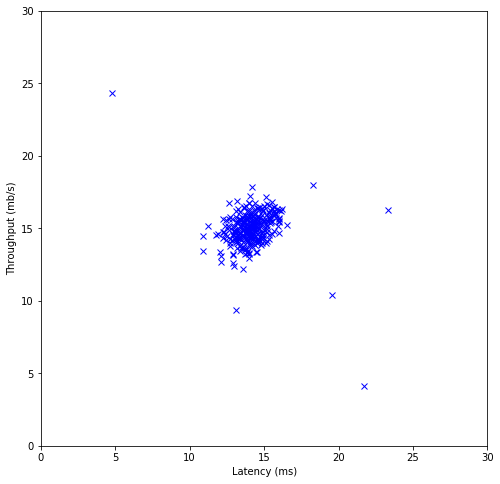

In [3]:
#  Visualize the example dataset
# Create New Figure
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(X[:, 0], X[:, 1], 'bx');
plt.xlim([0,30])
plt.ylim([0,30])
# Labels
plt.xlabel('Latency (ms)');
plt.ylabel('Throughput (mb/s)');

#### ================== Part 2: Estimate the dataset statistics ===================
  For this exercise, we assume a Gaussian distribution for the dataset.

  We first estimate the parameters of our assumed Gaussian distribution, 
  then compute the probabilities for each of the points and then visualize 
  both the overall distribution and where each of the points falls in 
  terms of that distribution.

In [4]:
def estimateGaussian(X):
    #ESTIMATEGAUSSIAN This function estimates the parameters of a 
    #Gaussian distribution using the data in X
    #   [mu sigma2] = estimateGaussian(X), 
    #   The input X is the dataset with each n-dimensional data point in one row
    #   The output is an n-dimensional vector mu, the mean of the data set
    #   and the variances sigma^2, an n x 1 vector
    # 

    # Useful variables
    [m, n] = np.shape(X);

    # You should return these values correctly
    mu = np.zeros((n, 1));
    sigma2 = np.zeros((n, 1));

    # ====================== YOUR CODE HERE ======================
    # Instructions: Compute the mean of the data and the variances
    #               In particular, mu(i) should contain the mean of
    #               the data for the i-th feature and sigma2(i)
    #               should contain variance of the i-th feature.
    #
    OPT = 0; # calculate variance by dividing by n
    DIM = 0; # calculate summary statistics for each columnn;

    mu = np.mean(X, axis=DIM);
    sigma2 = np.var(X, ddof=OPT, axis=DIM);
    return mu, sigma2

In [5]:
print('Visualizing Gaussian fit.\n');

#  Estimate my and sigma2
[mu, sigma2] = estimateGaussian(X);
print(mu)
print(sigma2)
print('mu: {0:0.5f}\t sigma: {1:0.5f}'.format(mu[0], sigma2[0]))

Visualizing Gaussian fit.

[ 14.11222578  14.99771051]
[ 1.83263141  1.70974533]
mu: 14.11223	 sigma: 1.83263


In [6]:
def multivariateGaussian(X, mu, Sigma2):
    #MULTIVARIATEGAUSSIAN Computes the probability density function of the
    #multivariate gaussian distribution.
    #    p = MULTIVARIATEGAUSSIAN(X, mu, Sigma2) Computes the probability 
    #    density function of the examples X under the multivariate gaussian 
    #    distribution with parameters mu and Sigma2. If Sigma2 is a matrix, it is
    #    treated as the covariance matrix. If Sigma2 is a vector, it is treated
    #    as the \sigma^2 values of the variances in each dimension (a diagonal
    #    covariance matrix)
    #

    k = np.size(mu);

    if ((np.ndim(Sigma2) == 1)):
        Sigma2 = np.diag(Sigma2);
    part1 = 1 / (((2 * np.pi) ** (k / 2)) * (np.linalg.det(Sigma2) ** (1/2)))
    part2 = (-1/2) * np.sum(np.multiply(np.dot((X - mu),np.linalg.inv(Sigma2)),(X - mu)),axis=1);
    p = part1 * np.exp(part2);
    return p

In [7]:
#  Returns the density of the multivariate normal at each data point (row) 
#  of X
p = multivariateGaussian(X, mu, sigma2);

In [8]:
def visualizeFit(X, mu, sigma2):
    #VISUALIZEFIT Visualize the dataset and its estimated distribution.
    #   VISUALIZEFIT(X, p, mu, sigma2) This visualization shows you the 
    #   probability density function of the Gaussian distribution. Each example
    #   has a location (x1, x2) that depends on its feature values.
    #
    
    # generate the grid range
    u = np.linspace(0, 35, 71);
    v = np.linspace(0, 35, 71);
    uu, vv = np.meshgrid(u, v)

    z = multivariateGaussian(np.hstack([uu.reshape(-1,1), vv.reshape(-1,1)]), mu, sigma2);
    z = z.reshape(uu.shape)

    # generate the figure
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, aspect='equal')
    # plot data points
    ax.plot(X[:, 0], X[:, 1], 'bx');
    # plot contours
    levels = 10.**np.arange(-20,0,3)
    ax.contour(uu, vv, z, levels=levels, linewidth=2);
    # Labels
    plt.xlabel('Latency (ms)');
    plt.ylabel('Throughput (mb/s)');
    return ax;

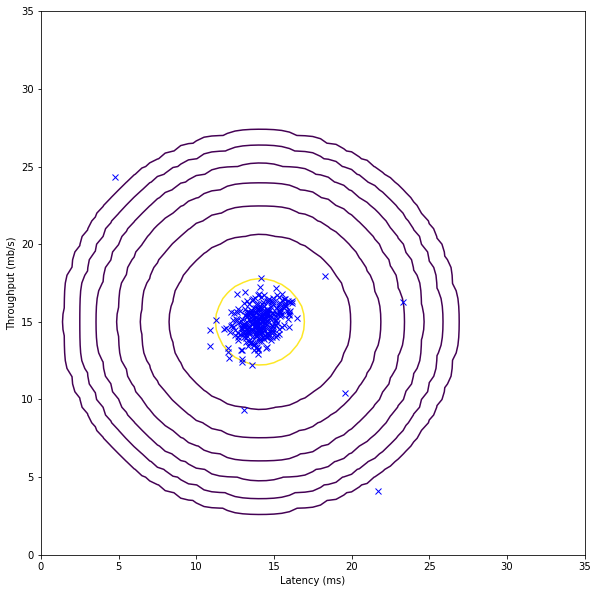

In [9]:
ax = visualizeFit(X, mu, sigma2);

#### ================== Part 3: Find Outliers ===================
Now you will find a good epsilon threshold using a cross-validation set probabilities given the estimated Gaussian distribution

In [10]:
import warnings

def selectThreshold(yval, pval):
    #SELECTTHRESHOLD Find the best threshold (epsilon) to use for selecting
    #outliers
    #   [bestEpsilon bestF1] = SELECTTHRESHOLD(yval, pval) finds the best
    #   threshold to use for selecting outliers based on the results from a
    #   validation set (pval) and the ground truth (yval).
    #

    # ====================== YOUR CODE HERE ======================
    # Instructions: Compute the F1 score of choosing epsilon as the
    #               threshold and place the value in F1. The code at the
    #               end of the loop will compare the F1 score for this
    #               choice of epsilon and set it to be the best epsilon if
    #               it is better than the current choice of epsilon.
    #               
    # Note: You can use predictions = (pval < epsilon) to get a binary vector
    #       of 0's and 1's of the outlier predictions
 
    bestEpsilon = 0;
    bestF1 = 0;
    F1 = 0;
    nsteps = 1000;
    stepsize = (np.max(pval) - np.min(pval)) / nsteps;
    
    epsilonRng = np.tile(np.arange(min(pval), max(pval)+stepsize, step=stepsize), (np.shape(pval)[0], 1));
  
    pval = pval.reshape(-1,1)
    pvalM = np.tile(pval, (1, nsteps + 1));
    
    predictions = (pval < epsilonRng);
    
    tp = np.sum((predictions == 1) & (yval == 1),axis=0);
    fp = np.sum((predictions == 1) & (yval == 0),axis=0);
    tn = np.sum((predictions == 0) & (yval == 0),axis=0);
    fn = np.sum((predictions == 0) & (yval == 1),axis=0);

    warnings.simplefilter('ignore') # removing the divide by zero error temporarily
    precision = tp / (tp + fp);
    recall = tp / (tp + fn);
    warnings.simplefilter('default') # restore default warning settings
    
    F1 = (2 * precision * recall) / (precision + recall);
   
    idxBestF1 = np.nanargmax(F1)
    bestF1 = F1[idxBestF1];
    bestEpsilon = epsilonRng[1, idxBestF1];

    # =============================================================

    return bestEpsilon, bestF1

Best epsilon found using cross-validation: 8.99e-05
Best F1 on Cross Validation Set:  0.875000
   (you should see a value epsilon of about 8.99e-05)
   (you should see a Best F1 value of  0.875000)



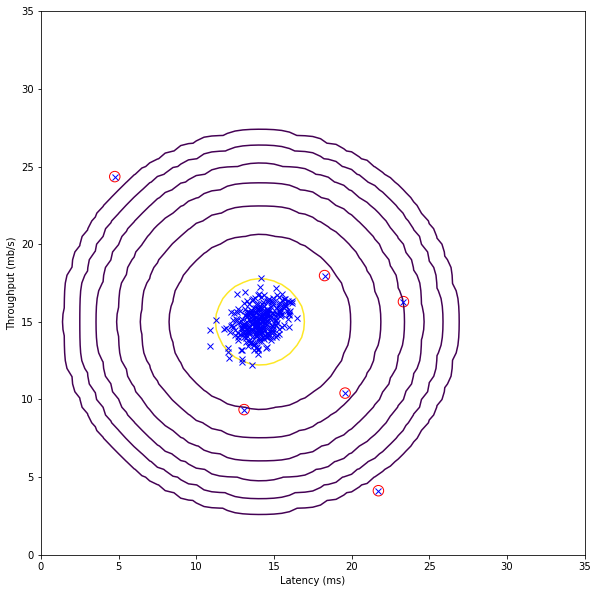

In [11]:
pval = multivariateGaussian(Xval, mu, sigma2);

[epsilon, F1] = selectThreshold(yval, pval);

print('Best epsilon found using cross-validation: {0:0.2e}'.format(epsilon));
print('Best F1 on Cross Validation Set:  {0:0.6f}'.format(F1));
print('   (you should see a value epsilon of about 8.99e-05)');
print('   (you should see a Best F1 value of  0.875000)\n');

#  Find the outliers in the training set and plot the
outliers = np.where(p < epsilon)[0]

# redraw the datapoints and contours
ax = visualizeFit(X, mu, sigma2);
#  Draw a red circle around the outliers
ax.scatter(X[outliers, 0], X[outliers, 1], s=110, color='r', marker='o', facecolors='none');

#### ================== Part 4: Multidimensional Outliers ===================

  We will now use the code from the previous part and apply it to a 
  harder problem in which more features describe each datapoint and only 
  some features indicate whether a point is an outlier.


In [12]:
# Load Training Data
print('Visualizing example dataset for outlier detection.\n');

# Load from ex8data2: 
#  Loads the second dataset. You should now have the
#  variables X, Xval, yval in your environment
mat_contents = sio.loadmat('ex8data2.mat');
print('   ...Done.')
print('\nContents of mat file...')
print(mat_contents.keys())
X = mat_contents['X'];
Xval = mat_contents['Xval'];
yval = mat_contents['yval'];

# m = Number of examples
m = np.shape(X)[0];
print('\n')
print('Dimensions of X: {0}'.format(X.shape));
print('Dimensions of Xval: {0}'.format(Xval.shape));
print('Dimensions of yval: {0}'.format(yval.shape));

Visualizing example dataset for outlier detection.

   ...Done.

Contents of mat file...
dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])


Dimensions of X: (1000, 11)
Dimensions of Xval: (100, 11)
Dimensions of yval: (100, 1)


####  Apply the same steps to the larger dataset

In [13]:
[mu, sigma2] = estimateGaussian(X);

#  Training set 
p = multivariateGaussian(X, mu, sigma2);

#  Cross-validation set
pval = multivariateGaussian(Xval, mu, sigma2);

#  Find the best threshold
[epsilon, F1] = selectThreshold(yval, pval);

print('Best epsilon found using cross-validation: {0:0.2e}'.format(epsilon));
print('Best F1 on Cross Validation Set:  {0:0.6f}'.format(F1));
print('   (you should see a value epsilon of about 1.38e-18)');
print('   (you should see a Best F1 value of 0.615385)\n');
print('# Outliers found: {0:d}\n'.format(np.sum(p < epsilon)));

Best epsilon found using cross-validation: 1.38e-18
Best F1 on Cross Validation Set:  0.615385
   (you should see a value epsilon of about 1.38e-18)
   (you should see a Best F1 value of 0.615385)

# Outliers found: 117



## Collaborative Filtering

#### =============== Part 1: Loading movie ratings dataset ================
  You will start by loading the movie ratings dataset to understand the
  structure of the data.
 

In [14]:
def load_ex8_movies():
    print('Loading movie ratings dataset.\n');

    # Load data from ex8_movies: 
    mat_contents = sio.loadmat('ex8_movies.mat');
    print('   ...Done.')
    print('\nContents of mat file...')
    print(mat_contents.keys())
    Y = mat_contents['Y'];
    R = mat_contents['R'];

    # m = Number of examples
    m = np.shape(Y)[0];
    print('')
    print('Dimensions of Y: {0}'.format(Y.shape));
    print('Dimensions of R: {0}'.format(R.shape));

    print('')
    print('Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 943 users')
    print('R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i')
    return Y, R;

Y, R = load_ex8_movies();

Loading movie ratings dataset.

   ...Done.

Contents of mat file...
dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

Dimensions of Y: (1682, 943)
Dimensions of R: (1682, 943)

Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 943 users
R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i


Average rating for movie 1 (Toy Story): 4.52 / 5




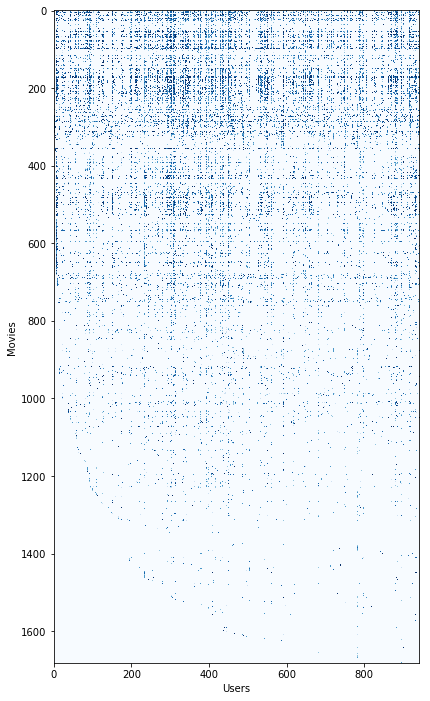

In [15]:
#  From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): {0:0.2f} / 5\n\n'.format(np.mean(Y[0, R[0, :]])));

#  We can "visualize" the ratings matrix by plotting it with imshow
fig, ax = plt.subplots(figsize=(12,12));
ax.imshow(Y, cmap='Blues')
plt.xlabel('Users');
plt.ylabel('Movies');

#### ============ Part 2: Collaborative Filtering Cost Function ===========
  You will now implement the cost function for collaborative filtering.
  To help you debug your cost function, we have included set of weights
  that we trained on that. Specifically, you should complete the code in 
  cofiCostFunc.m to return J.

In [16]:
#  Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
print('Loading pre-trained weights.\n');

# Load data from ex8_movieParams: 
mat_contents = sio.loadmat('ex8_movieParams.mat');
print('   ...Done.')
print('\nContents of mat file...')
print(mat_contents.keys())
X = mat_contents['X'];
Theta = mat_contents['Theta'];
num_users = mat_contents['num_users'];
num_movies = mat_contents['num_movies'];
num_features = mat_contents['num_features'];

print('')
print('Dimensions of X: {0}'.format(X.shape));
print('Dimensions of Theta: {0}'.format(Theta.shape));
print('Dimensions of num_users: {0}'.format(num_users.shape));
print('Dimensions of num_movies: {0}'.format(num_movies.shape));
print('Dimensions of num_features: {0}'.format(num_features.shape));


Loading pre-trained weights.

   ...Done.

Contents of mat file...
dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

Dimensions of X: (1682, 10)
Dimensions of Theta: (943, 10)
Dimensions of num_users: (1, 1)
Dimensions of num_movies: (1, 1)
Dimensions of num_features: (1, 1)


In [17]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_):
    #COFICOSTFUNC Collaborative filtering cost function
    #   [J, grad] = COFICOSTFUNC(params, Y, R, num_users, num_movies, ...
    #   num_features, lambda) returns the cost and gradient for the
    #   collaborative filtering problem.
    #

    # Ensure we have a 1 row matrix
    params = params.reshape(1, -1)
    # Unfold the U and W matrices from params
    X = params[0, :num_movies*num_features].reshape((num_movies, num_features));
    Theta = params[0, num_movies*num_features:].reshape((num_users, num_features));
    
    # You need to return the following values correctly
    J = 0;
    X_grad = np.zeros(X.shape);
    Theta_grad = np.zeros(Theta.shape);

    # ====================== YOUR CODE HERE ======================
    # Instructions: Compute the cost function and gradient for collaborative
    #               filtering. Concretely, you should first implement the cost
    #               function (without regularization) and make sure it is
    #               matches our costs. After that, you should implement the 
    #               gradient and use the checkCostFunction routine to check
    #               that the gradient is correct. Finally, you should implement
    #               regularization.
    #
    # Notes: X - num_movies  x num_features matrix of movie features
    #        Theta - num_users  x num_features matrix of user features
    #        Y - num_movies x num_users matrix of user ratings of movies
    #        R - num_movies x num_users matrix, where R(i, j) = 1 if the 
    #            i-th movie was rated by the j-th user
    #
    # You should set the following variables correctly:
    #
    #        X_grad - num_movies x num_features matrix, containing the 
    #                 partial derivatives w.r.t. to each element of X
    #        Theta_grad - num_users x num_features matrix, containing the 
    #                     partial derivatives w.r.t. to each element of Theta
    #

    J = (1/2) * np.sum(np.multiply(np.power(np.dot(X, Theta.T) - Y, 2), R));
    J_Reg = (lambda_ / 2) * np.sum(np.power(Theta, 2)) + (lambda_ / 2) * np.sum(np.power(X,2));
    J = J + J_Reg
    
    X_grad = np.dot(np.multiply(R, np.dot(X, Theta.T) - Y), Theta) + lambda_ * X;
    Theta_grad = np.dot(np.multiply(R, (np.dot(X, Theta.T) - Y)).T, X) + lambda_ * Theta;
    # =============================================================

    grad = np.hstack([X_grad.flatten(), Theta_grad.flatten()]);

    return [J, grad]

In [18]:
#  Reduce the data set size so that this runs faster
num_users = 4; 
num_movies = 5; 
num_features = 3;

X = np.matrix(X[:num_movies, :num_features]);
Theta = np.matrix(Theta[:num_users, :num_features]);
Y = np.matrix(Y[:num_movies, :num_users]);
R = np.matrix(R[:num_movies, :num_users]);

#  Evaluate cost function
[J, grad] = cofiCostFunc(np.hstack([X.flatten(), Theta.flatten()]), Y, R, num_users, num_movies, num_features, 0.0);

print('Cost at loaded parameters: {0:0.2f}'.format(J))
print('\t(this value should be about 22.22)');

Cost at loaded parameters: 22.22
	(this value should be about 22.22)


#### ============== Part 3: Collaborative Filtering Gradient ==============
  Once your cost function matches up with ours, you should now implement 
  the collaborative filtering gradient function. Specifically, you should 
  complete the code in cofiCostFunc.m to return the grad argument.

In [19]:
def computeNumericalGradient(J, theta):
    #COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
    #and gives us a numerical estimate of the gradient.
    #   numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
    #   gradient of the function J around theta. Calling y = J(theta) should
    #   return the function value at theta.

    # Notes: The following code implements numerical gradient checking, and 
    #        returns the numerical gradient.It sets numgrad(i) to (a numerical 
    #        approximation of) the partial derivative of J with respect to the 
    #        i-th input argument, evaluated at theta. (i.e., numgrad(i) should 
    #        be the (approximately) the partial derivative of J with respect 
    #        to theta(i).)
    #     
    numgrad = np.zeros(np.shape(theta));
    perturb = np.zeros(np.shape(theta));
    e = 1e-4;
    for p in np.arange(np.size(theta)):
        # Set perturbation vector
        perturb[0, p] = e;
        loss1, grad1 = J(theta - perturb);
        loss2, grad2 = J(theta + perturb);
        # Compute Numerical Gradient
        numgrad[0, p] = (loss2 - loss1) / (2*e);
        perturb[0, p] = 0;

    return numgrad;

In [31]:
from functools import partial

def checkCostFunction(cofiCostFunc, lambda_):
    #CHECKCOSTFUNCTION Creates a collaborative filering problem 
    #to check your cost function and gradients
    #   CHECKCOSTFUNCTION(lambda) Creates a collaborative filering problem 
    #   to check your cost function and gradients, it will output the 
    #   analytical gradients produced by your code and the numerical gradients 
    #   (computed using computeNumericalGradient). These two gradient 
    #   computations should result in very similar values.

    # Set lambda
    #if ~exist('lambda', 'var') || isempty(lambda_):
    #    lambda_ = 0;

    ## Create small problem
    X_t = np.random.rand(4, 3);
    Theta_t = np.random.rand(5, 3);

    # Zap out most entries
    Y = np.dot(X_t, Theta_t.T);
    Y[np.random.random(np.shape(Y)) > 0.5] = 0; # np.random.random is same as np.random.rand but former takes a tuple input
    R = np.zeros(np.shape(Y));
    R[Y != 0] = 1;
    
    ## Run Gradient Checking
    X = np.matrix(np.random.standard_normal(np.shape(X_t))); # np.random.standard_normal is same as np.random.randn but former takes a tuple input
    Theta = np.matrix(np.random.standard_normal(np.shape(Theta_t)));

    num_users = np.shape(Y)[1];
    num_movies = np.shape(Y)[0];
    num_features = np.shape(Theta_t)[1];

    cost_partial = partial(cofiCostFunc, Y=Y, R=R, num_users=num_users, num_movies=num_movies, 
                                    num_features=num_features, lambda_=lambda_)
    
    numgrad = computeNumericalGradient(cost_partial, np.hstack([X.flatten(), Theta.flatten()]));
    
    [cost, grad] = cofiCostFunc(np.hstack([X.flatten(), Theta.flatten()]), 
                                Y, R, num_users, num_movies, num_features, lambda_);
    
    print(np.hstack([numgrad.reshape(-1,1), grad.reshape(-1,1)]));
    print('\nThe above two columns you get should be very similar.\n')
    print('(Left-Your Numerical Gradient, Right-Analytical Gradient)\n');

    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad);

    print('If your cost function implementation is correct, then')
    print('the relative difference will be small (less than 1e-9).')
    print('\nRelative Difference: {0:0.2e}'.format(diff));


In [32]:
print('\nChecking Gradients (without regularization) ... \n');

#  Check gradients by running checkNNGradients
checkCostFunction(cofiCostFunc, 0);


Checking Gradients (without regularization) ... 

[[ -0.15585172  -0.15585172]
 [ -0.02190909  -0.02190909]
 [ -0.34183975  -0.34183975]
 [  2.01739625   2.01739625]
 [  1.57107231   1.57107231]
 [  6.12219142   6.12219142]
 [ -7.62707222  -7.62707222]
 [ -3.11757649  -3.11757649]
 [ -6.65964173  -6.65964173]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ -3.1162281   -3.1162281 ]
 [ -1.60709708  -1.60709708]
 [ -9.00446928  -9.00446928]
 [ -0.21708051  -0.21708051]
 [  0.81378348   0.81378348]
 [ -2.34798421  -2.34798421]
 [  4.48029625   4.48029625]
 [ 13.39407137  13.39407137]
 [  7.46927917   7.46927917]
 [ -0.4239001   -0.4239001 ]
 [  1.58910121   1.58910121]
 [ -4.58498436  -4.58498436]
 [  0.32064051   0.32064051]
 [ -0.02254181  -0.02254181]
 [ -0.24639731  -0.24639731]]

The above two columns you get should be very similar.

(Left-Your Numerical Gradient, Right-Analytical Gradient)

If your cost function implementation is correct, t

#### ========= Part 4: Collaborative Filtering Cost Regularization ========
  Now, you should implement regularization for the cost function for 
  collaborative filtering. You can implement it by adding the cost of
  regularization to the original cost computation.
  

In [33]:
#  Evaluate cost function
J, grad = cofiCostFunc(np.hstack([X.flatten(), Theta.flatten()]), Y, R, num_users, num_movies, num_features, 1.5);
           
print('Cost at loaded parameters (lambda = 1.5): {0:0.2f} '.format(J))
print('\t(this value should be about 31.34)');

Cost at loaded parameters (lambda = 1.5): 666186.49 
	(this value should be about 31.34)


#### ======= Part 5: Collaborative Filtering Gradient Regularization ======
  Once your cost matches up with ours, you should proceed to implement 
  regularization for the gradient. 

In [34]:
print('\nChecking Gradients (with regularization) ... \n');

#  Check gradients by running checkNNGradients
checkCostFunction(cofiCostFunc, 1.5);


Checking Gradients (with regularization) ... 

[[ 0.78624346  0.78624346]
 [ 1.38270797  1.38270797]
 [-1.21260116 -1.21260116]
 [-1.44436141 -1.44436141]
 [-3.69313157 -3.69313157]
 [-0.60533462 -0.60533462]
 [-5.58674426 -5.58674426]
 [ 4.31459985  4.31459985]
 [-3.48393201 -3.48393201]
 [-0.25085583 -0.25085583]
 [-6.88752727 -6.88752727]
 [ 0.58309974  0.58309974]
 [ 5.2484936   5.2484936 ]
 [-1.7719459  -1.7719459 ]
 [ 5.48575111  5.48575111]
 [ 1.43817458  1.43817458]
 [ 3.65334693  3.65334693]
 [ 0.58093663  0.58093663]
 [ 1.2201631   1.2201631 ]
 [-6.22074864 -6.22074864]
 [ 2.1518787   2.1518787 ]
 [ 1.74733371  1.74733371]
 [ 0.67829248  0.67829248]
 [ 0.20132966  0.20132966]
 [-0.28684126 -0.28684126]
 [-0.36136316 -0.36136316]
 [-0.31019952 -0.31019952]]

The above two columns you get should be very similar.

(Left-Your Numerical Gradient, Right-Analytical Gradient)

If your cost function implementation is correct, then
the relative difference will be small (less than 1e-9

#### ============== Part 6: Entering ratings for a new user ===============
  Before we will train the collaborative filtering model, we will first
  add ratings that correspond to a new user that we just observed. This
  part of the code will also allow you to put in your own ratings for the
  movies in our dataset!

In [24]:
def loadMovieList():
    #GETMOVIELIST reads the fixed movie list in movie.txt and returns a
    #cell array of the words
    #   movieList = GETMOVIELIST() reads the fixed movie list in movie.txt 
    #   and returns a cell array of the words in movieList.

    ## Read the fixed movieulary list
    fname = 'movie_ids.txt'
    with open(fname, encoding='latin-1') as f:
        content = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content]
    # split each line after the first space. The index will be placed in the first column of matrix.
    content = np.matrix([x.split(' ', 1) for x in content])
    #print(content[:,0])
    return content;

In [25]:
movieList = loadMovieList();
print(movieList)

#  Initialize my ratings
my_ratings = np.zeros((1682, 1));

# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
my_ratings[0, 0] = 4;

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97, 0] = 2;

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[6, 0] = 3;
my_ratings[11, 0]= 5;
my_ratings[53, 0] = 4;
my_ratings[63, 0]= 5;
my_ratings[65, 0]= 3;
my_ratings[68, 0] = 5;
my_ratings[182, 0] = 4;
my_ratings[225, 0] = 5;
my_ratings[354, 0]= 5;

print('\n\nNew user ratings:\n');
for i in np.arange(np.size(my_ratings)):
    if my_ratings[i, 0] > 0:
        print('Rated {0:0.0f} for {1:s}'.format(my_ratings[i, 0], movieList[i, 1]));

[['1' 'Toy Story (1995)']
 ['2' 'GoldenEye (1995)']
 ['3' 'Four Rooms (1995)']
 ..., 
 ['1680' 'Sliding Doors (1998)']
 ['1681' 'You So Crazy (1994)']
 ['1682' 'Scream of Stone (Schrei aus Stein) (1991)']]


New user ratings:

Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
Rated 5 for Die Hard 2 (1990)
Rated 5 for Sphere (1998)


#### ================== Part 7: Learning Movie Ratings ====================
  Now, you will train the collaborative filtering model on a movie rating 
  dataset of 1682 movies and 943 users

In [26]:
print('\nTraining collaborative filtering...\n');

#  Load data
Y, R = load_ex8_movies();


Training collaborative filtering...

Loading movie ratings dataset.

   ...Done.

Contents of mat file...
dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

Dimensions of Y: (1682, 943)
Dimensions of R: (1682, 943)

Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 943 users
R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i


In [27]:
def normalizeRatings(Y, R):
    #NORMALIZERATINGS Preprocess data by subtracting mean rating for every 
    #movie (every row)
    #   [Ynorm, Ymean] = NORMALIZERATINGS(Y, R) normalized Y so that each movie
    #   has a rating of 0 on average, and returns the mean rating in Ymean.
    #
    
    [m, n] = np.shape(Y);
    Ymean = np.zeros((m, 1));
    Ynorm = np.zeros(np.shape(Y));
    for i in np.arange(m):
        idx = np.where(R[i, :] == 1)[0];
        Ymean[i, 0] = np.mean(Y[i, idx]);
        Ynorm[i, idx] = Y[i, idx] - Ymean[i, 0];

    return Ynorm, Ymean;

In [28]:
#  Add our own ratings to the data matrix
Y = np.hstack([my_ratings, Y]);
R = np.hstack([(my_ratings != 0), R]);

print('Y.shape:', Y.shape, '\tR.shape:', R.shape, '\tmy_ratings.shape:', my_ratings.shape) 

#  Normalize Ratings
[Ynorm, Ymean] = normalizeRatings(Y, R);

Y.shape: (1682, 944) 	R.shape: (1682, 944) 	my_ratings.shape: (1682, 1)


In [36]:
from scipy.optimize import minimize

#  Useful Values
num_users = np.shape(Y)[1];
num_movies = np.shape(Y)[0];
num_features = 10;
lambda_ = 10;

print('num_users:', num_users, '\tnum_movies:', num_movies, '\tnum_features:', num_features, '\tlambda_:', lambda_ , '\n') 

# Set Initial Parameters (Theta, X)
X = np.random.standard_normal((num_movies, num_features));
Theta = np.random.standard_normal((num_users, num_features));

initial_parameters = np.matrix(np.hstack([X.flatten(), Theta.flatten()]))

Xdash = initial_parameters[0, :num_movies*num_features].reshape((num_movies, num_features));

# Create "short hand" for the cost function to be minimized
cost_partial = partial(cofiCostFunc, Y=Ynorm, R=R, num_users=num_users, num_movies=num_movies, 
                                    num_features=num_features, lambda_=lambda_)
# Now, cost_partial is a function that takes in only one argument

print('Started recommender system learning ...');
# Minimize using scipy.optimize.minimize
Result = minimize(fun = cost_partial, 
                         x0 = initial_parameters,
                         args = (),
                         method = 'L-BFGS-B',
                         jac = True, # set to true as costFunction returns both the cost and gradient
                         options={'disp': True, 
                                  'gtol': 1e-05, 
                                  'maxiter': 100});

optimal_theta = Result.x;
cost = Result.fun;

# Unfold the returned theta back into U and W
X = optimal_theta[:num_movies*num_features].reshape(num_movies, num_features);
Theta = optimal_theta[num_movies*num_features:].reshape(num_users, num_features);

print('... Recommender system learning completed.\n');
print('optimal cost is: {0:0.1f}'.format(cost));

num_users: 944 	num_movies: 1682 	num_features: 10 	lambda_: 10 

Started recommender system learning ...
... Recommender system learning completed.

optimal cost is: 38970.2


#### ================== Part 8: Recommendation for you ====================
  After training the model, you can now make recommendations by computing
  the predictions matrix.

In [30]:
p = np.dot(X, Theta.T);
my_predictions = p[:,0].reshape(-1,1) + Ymean;

movieList = loadMovieList();

ix = np.argsort(my_predictions, axis=0)[::-1];

print('\nTop recommendations for you:\n');

for i in np.arange(10):
    j = ix[i];
    print('Predicting rating {0:0.5f} for movie {1:s}'.format(my_predictions[j][0, 0], movieList[j][0, 1]));
    
print('\n\nOriginal ratings provided:\n');
for i in np.arange(np.size(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated {0:0.1f} for {1:s}'.format(my_ratings[i][0], movieList[i][0, 1]));


Top recommendations for you:

Predicting rating 5.00003 for movie Star Kid (1997)
Predicting rating 5.00002 for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.00002 for movie Someone Else's America (1995)
Predicting rating 5.00000 for movie Great Day in Harlem, A (1994)
Predicting rating 5.00000 for movie They Made Me a Criminal (1939)
Predicting rating 4.99999 for movie Prefontaine (1997)
Predicting rating 4.99999 for movie Saint of Fort Washington, The (1993)
Predicting rating 4.99999 for movie Aiqing wansui (1994)
Predicting rating 4.99999 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 4.99997 for movie Santa with Muscles (1996)


Original ratings provided:

Rated 4.0 for Toy Story (1995)
Rated 3.0 for Twelve Monkeys (1995)
Rated 5.0 for Usual Suspects, The (1995)
Rated 4.0 for Outbreak (1995)
Rated 5.0 for Shawshank Redemption, The (1994)
Rated 3.0 for While You Were Sleeping (1995)
Rated 5.0 for Forrest Gump (1994)
Rated 2.0 for